# Lab 5 - Joining Uber Pick-Ups, Stations, and Boroughs

In [Lecture 3.4](./3_4_joining_large_and_small_files.ipynb), we introduced using a Python `dict` to join a large and small table.  In this lab, we will practice this technique on the uber data set.

**Note:** Make sure that you download and unzip the file `Uber-Jan-Feb-FOIL.csv` before proceeding.

In [3]:
import pandas as pd
from dfply import *
from toolz import first
from calendar import day_name
import numpy as np
from functoolz import pipeable

In [2]:
c_size = 500000
trips = pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-janjune-15.csv", chunksize=c_size,parse_dates=['Pickup_date'])
first_chunk = next(trips)

In [3]:
first_chunk.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


## <font color="red"> Problem 1 - Creating 2 Location `dict`</font>

Read the file `taxi-zone-lookup.csv` and inspect the columns. What 2 pieces of information will this file allow us to add to the `uber-raw-data-janjune-15.csv`?  Make a `dict` for each of these variables.

This file allows us to add the Borough and Zone based on the LocationID.

In [4]:
taxi_zone_lookup = pd.read_csv("./data/uber/uber-trip-data/taxi-zone-lookup.csv")
taxi_zone_lookup.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [5]:
bor_dict = {id_:bor for id_,bor in zip(taxi_zone_lookup.LocationID,taxi_zone_lookup.Borough)}

In [6]:
zone_dict = {id_:zone for id_,zone in zip(taxi_zone_lookup.LocationID,taxi_zone_lookup.Zone)}

## <font color="red"> Problem 2 - Dispatch Translation</font>

The following table was taken from the FiveThirtyEight github page and contains the names of each Uber dispatch station.  Create a translation `dict` for these data.

Base Code | Base Name
---|---------
B02512 | Unter
B02598 | Hinter
B02617 | Weiter
B02682 | Schmecken
B02764 | Danach-NY
B02765 | Grun
B02835 | Dreist
B02836 | Drinnen

In [7]:
base_dict = {'B02512':'Unter',
            'B02598':'Hinter',
            'B02617':'Weiter',
            'B02682':'Schmecken',
            'B02764':'Danach-NY',
            'B02765':'Grun',
            'B02835':'Dreist',
            'B02836':'Drinnen',}

## <font color="red"> Problem 3 - Prototyping a Helper Function</font>

Use the first chunk to prototype a helper function that

1. Add four new columns, one for each key/translation.
2. Drop each of the associated keys.
3. Convert the `pickup_date` to a datetime column.
4. Add various datepart columns

This function should use appropriate `dfply` functions and a pipe.

In [8]:
def to_datetime(series, infer_datetime_format=True):
    return pd.to_datetime(series, infer_datetime_format=infer_datetime_format)

In [9]:
first_chunk.Pickup_date = to_datetime(first_chunk.Pickup_date)
first_chunk_clean = (first_chunk >>
                    mutate(borough = X.locationID.map(bor_dict),
                          zone = X.locationID.map(zone_dict),
                          dispatching_base = X.Dispatching_base_num.map(base_dict),
                          affiliated_base = X.Affiliated_base_num.map(base_dict),
                          weekday = X.Pickup_date.dt.weekday_name,
                          weekofyear = X.Pickup_date.dt.weekofyear,
                          dayofyear = X.Pickup_date.dt.dayofyear,
                          year = X.Pickup_date.dt.year,
                          month = X.Pickup_date.dt.month_name(),
                          day = X.Pickup_date.dt.day,
                          hour = X.Pickup_date.dt.hour
                          ) >>
                    drop(X.locationID,X.Dispatching_base_num,X.Affiliated_base_num)
                    )
first_chunk_clean.head()

,Pickup_date,borough,zone,dispatching_base,affiliated_base,weekday,weekofyear,dayofyear,year,month,day,hour
0,2015-05-17 09:47:00,Manhattan,Lenox Hill West,Weiter,Weiter,Sunday,20,137,2015,May,17,9
1,2015-05-17 09:47:00,Brooklyn,Downtown Brooklyn/MetroTech,Weiter,Weiter,Sunday,20,137,2015,May,17,9
2,2015-05-17 09:47:00,Manhattan,Garment District,Weiter,Weiter,Sunday,20,137,2015,May,17,9
3,2015-05-17 09:47:00,Brooklyn,East Williamsburg,Weiter,NaN,Sunday,20,137,2015,May,17,9
4,2015-05-17 09:47:00,Manhattan,Flatiron,Weiter,Weiter,Sunday,20,137,2015,May,17,9


In [10]:
uber_clean_func = pipeable(lambda df: (df >>
                                     mutate(borough = X.locationID.map(bor_dict),
                                          zone = X.locationID.map(zone_dict),
                                          dispatching_base = X.Dispatching_base_num.map(base_dict),
                                          affiliated_base = X.Affiliated_base_num.map(base_dict),
                                          weekday = X.Pickup_date.dt.weekday_name,
                                          weekofyear = X.Pickup_date.dt.weekofyear,
                                          dayofyear = X.Pickup_date.dt.dayofyear,
                                          year = X.Pickup_date.dt.year,
                                          month = X.Pickup_date.dt.month_name(),
                                          day = X.Pickup_date.dt.day,
                                          hour = X.Pickup_date.dt.hour
                                          ) >>
                                    drop(X.locationID,X.Dispatching_base_num,X.Affiliated_base_num)))

In [11]:
first_chunk_c = uber_clean_func(first_chunk)
first_chunk_c.head()

,Pickup_date,borough,zone,dispatching_base,affiliated_base,weekday,weekofyear,dayofyear,year,month,day,hour
0,2015-05-17 09:47:00,Manhattan,Lenox Hill West,Weiter,Weiter,Sunday,20,137,2015,May,17,9
1,2015-05-17 09:47:00,Brooklyn,Downtown Brooklyn/MetroTech,Weiter,Weiter,Sunday,20,137,2015,May,17,9
2,2015-05-17 09:47:00,Manhattan,Garment District,Weiter,Weiter,Sunday,20,137,2015,May,17,9
3,2015-05-17 09:47:00,Brooklyn,East Williamsburg,Weiter,NaN,Sunday,20,137,2015,May,17,9
4,2015-05-17 09:47:00,Manhattan,Flatiron,Weiter,Weiter,Sunday,20,137,2015,May,17,9


## <font color="red"> Problem 4 - Creating a SQL database</font>

Use `pandas` and your helper function to create a `sqlite` database for this file.

In [12]:
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(start, start + len(df))
                                              )))
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> uber_clean_func >> add_primary_key(i*c_size))

In [13]:
from more_sqlalchemy import get_sql_types
i=0
complete_first_chunk = first_chunk >> uber_clean_func >> add_primary_key(i)
sql_types = get_sql_types(complete_first_chunk)
sql_types

{'Pickup_date': sqlalchemy.sql.sqltypes.DateTime,
 'borough': sqlalchemy.sql.sqltypes.String,
 'zone': sqlalchemy.sql.sqltypes.String,
 'dispatching_base': sqlalchemy.sql.sqltypes.String,
 'affiliated_base': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer,
 'month': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer}

In [16]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber_lab_5.db', echo=False)

In [17]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber_lab_5', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber_lab_5 (
	"Pickup_date" DATETIME, 
	borough VARCHAR, 
	zone VARCHAR, 
	dispatching_base VARCHAR, 
	affiliated_base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_lab_5_pk PRIMARY KEY (id)
)




In [25]:
c_size = 500000
df_iter = enumerate(pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-janjune-15.csv", 
                                header=0,
                                parse_dates=['Pickup_date'],
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [26]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber_lab_5', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0
writing chunk 1
writing chunk 2
writing chunk 3
writing chunk 4
writing chunk 5
writing chunk 6
writing chunk 7
writing chunk 8
writing chunk 9
writing chunk 10
writing chunk 11
writing chunk 12
writing chunk 13
writing chunk 14
writing chunk 15
writing chunk 16
writing chunk 17
writing chunk 18
writing chunk 19
writing chunk 20
writing chunk 21
writing chunk 22
writing chunk 23
writing chunk 24
writing chunk 25
writing chunk 26
writing chunk 27
writing chunk 28


## <font color="red"> Problem 5 - Exploring the pickups</font>

**Question of Interest:** I am interested in difference between pick-ups in terms of both time and Borough.  Use aggregation and visualizations to construct a group that illustrates an interesting difference between the Boroughs.

In [4]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber_lab_5.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber_lab_5

In [5]:
from sqlalchemy import select, func
stmt = (select([Uber.hour, 
               func.count(Uber.hour).label('cnt'),
               Uber.borough])
        .group_by(Uber.hour,Uber.borough))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts.head()

,hour,cnt,borough
0,0,8923,Bronx
1,0,118731,Brooklyn
2,0,414082,Manhattan
3,0,60003,Queens
4,0,185,Staten Island


In [11]:
cnts2 = (cnts >> 
         group_by(X.borough) >>
         mutate(total = X.cnt.sum()) >>
         mutate(proportion = X.cnt/X.total))
cnts2.head()

,hour,cnt,borough,total,proportion
0,0,8923,Bronx,220146,0.040532
6,1,6446,Bronx,220146,0.029281
13,2,4811,Bronx,220146,0.021854
19,3,3969,Bronx,220146,0.018029
25,4,3731,Bronx,220146,0.016948


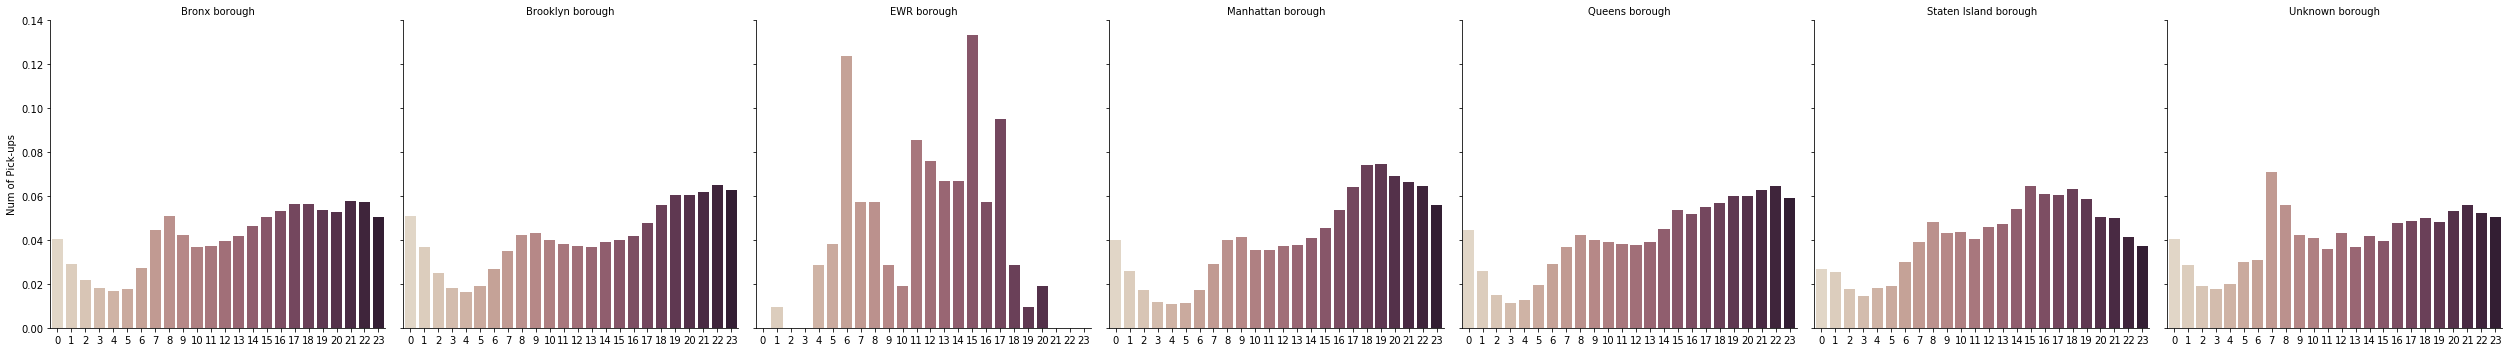

In [15]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="hour", 
               y = 'proportion',
               col = 'borough',
               kind="bar", 
               palette="ch:.25", 
               data=cnts2))

(ax.set_axis_labels("", "Num of Pick-ups")
   .set_titles("{col_name} {col_var}"))

plt.tight_layout()
plt.show()
